In [1]:
# HELPER FUNCTIONS

import collections

def get_mean_metrics(models, metric_type):
    mean_acc_fedavg = []
    for model in models["result"]:
        model_id = model["model"]
        validations = client.list_validations(modelId=model_id)

        acc = []
        for _, validation in validations.items(): 
            metrics = json.loads(validation['data'])
            if metric_type in metrics:
                acc.append(metrics[metric_type])

        if acc:
            mean_acc_fedavg.append(np.mean(acc))

    return np.min(mean_acc_fedavg)

def get_baseline_metrics(baseline_session_id):
    models = client.list_models(baseline_session_id)

    baseline_metrics = {
        'train_target_misclassification': get_mean_metrics(models, 'train_target_misclassification'),
        'test_target_misclassification': get_mean_metrics(models, 'test_target_misclassification')
    }

    return baseline_metrics

In [2]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

import sys
sys.path.append('/home/ubuntu/fedn-attack-sim-uu/examples/mnist-pytorch')

from combiner_config import COMBINER_IP

DISCOVER_HOST = COMBINER_IP
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

In [3]:
[session['session_id'] for session in client.list_sessions()['result']]

['MNIST_BD35IN03P_25R_16_04',
 'MNIST_BD35IN__P_25R_TAKE02_20_00',
 'MNIST_BD35IN03P_25R_TAKE03_19_01',
 'MNIST_BD35IN03P_25R_TAKE03_18_02',
 'MNIST_BD35IN03P_25R_TAKE02_18_02',
 'MNIST_BD35IN03P_25R_TAKE01_18_02',
 'MNIST_BD35IN03P_25R_TAKE02_19_01',
 'MNIST_BD35IN03P_25R_19_01_TAKE02',
 'MNIST_BD35IN__P_25R_20_00',
 'TEST_FINAL_01_18_02',
 'MNIST_BD35IN03P_25R_18_02_T3',
 'MNIST_BD35IN03P_25R_18_02_T2',
 'MNIST_BD35IN03P_25R_18_02_T1',
 'MNIST_BD35IN03P_25R_18_02',
 'MNIST_BD35IN03P_25R_19_01',
 'MNIST_BD__IN_25R_20_00',
 'MNIST_BD35IN_25R_19_01_T1',
 'MNIST_BD35IN_25R_19_01_V2',
 'MNIST_BD35IN_25R_19_01',
 'TEST_05',
 'TEST_04',
 'TEST_03',
 'MNIST_AB35IN_25R_08_12',
 'MNIST_AB35IN_25R_12_08',
 'TEST_02',
 'MNIST_AB35IN_25R_14_06',
 'MNIST_AB35IN_25R_16_04',
 'MNIST_GBM001_25R_18_02',
 'MNIST_AB35IN_25R_09_01',
 'MNIST_AB35IN_25R_18_02_V2',
 'TEST',
 'MNIST_AB35IN_25R_18_02',
 'MNIST_AB35IN_25R_19_01',
 'MNIST_AB__IN_25R_20_00']

In [4]:
session_id = input("Provide a session_id: ")

Provide a session_id:  MNIST_BD35IN03P_25R_16_04


In [5]:
baseline_metrics = get_baseline_metrics(input("Provide baseline session_id: "))

Provide baseline session_id:  MNIST_BD35IN__P_25R_20_00


In [6]:
models = client.list_models(session_id)

num_rounds = models['count']
# num_rounds

# Provides a model trail for a given session (in FILO) --> need to be reversed
model_trail = models['result']
model_trail.reverse()
# model_trail

In [7]:
# client.list_validations(modelId = model_trail[20]['model'])['663757fd981afd046cebee22']

In [8]:
# json.loads(client.list_validations(modelId = model_trail[20]['model'])['663757fd981afd046cebee22']['data'])

In [9]:
# for round in range(num_rounds):
#     for client_model in client.list_validations(modelId = model_trail[round]['model']).keys():
#         print(json.loads(client.list_validations(modelId = model_trail[round]['model'])[client_model]['data'])['train_target_misclassification'])

In [10]:
validations = []

for model_instance in model_trail:
    worker_results = client.list_validations(modelId=model_instance['model'])
    result_ids = [result_id for result_id in worker_results]
    for result_id in result_ids:
        worker_result = worker_results.get(result_id)
        client_type = 'benign'
        
        if 'malicious' in worker_result['sender']['name']:
            client_type = 'malicious'
            
        validation = {
            'model_committed_at': model_instance['committed_at'],
            'session_id': model_instance['session_id'],
            'model': model_instance['model'],
            'client_name': worker_result['sender']['name'],
            'client_role': worker_result['sender']['role'],
            'client_type': client_type,
            'train_target_misclassification': json.loads(worker_result['data'])['train_target_misclassification'],
            'test_target_misclassification': json.loads(worker_result['data'])['test_target_misclassification'],
            'train_target_prediction_dist': json.loads(worker_result['data'])['train_target_prediction_dist'],
            'test_target_prediction_dist': json.loads(worker_result['data'])['test_target_prediction_dist']
        }
        
        validations.append(validation)

In [11]:
validations[0]

{'model_committed_at': 'Thu, 09 May 2024 20:50:31 GMT',
 'session_id': 'MNIST_BD35IN03P_25R_16_04',
 'model': '90fe9c8c-d2c3-4520-8a6c-b0ad693bf279',
 'client_name': 'benign_client8',
 'client_role': 'WORKER',
 'client_type': 'benign',
 'train_target_misclassification': 0.966542750929368,
 'test_target_misclassification': 0.9811320754716981,
 'train_target_prediction_dist': [50, 0, 3, 44, 131, 0, 0, 11, 9, 21],
 'test_target_prediction_dist': [12, 0, 0, 11, 24, 0, 0, 3, 1, 2]}

In [12]:
graph_data = {
    'train_target_misclassification': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_target_misclassification': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'train_target_prediction_dist': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_target_prediction_dist': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'overall_train_target_misclassification': [],
    'overall_test_target_misclassification': [],
    'overall_train_target_prediction_dist': [],
    'overall_test_target_prediction_dist': []
}

In [13]:
for validation in validations:
    graph_data['train_target_misclassification'][validation['client_name']]['data'].append(validation['train_target_misclassification'])
    graph_data['test_target_misclassification'][validation['client_name']]['data'].append(validation['test_target_misclassification'])
    graph_data['train_target_prediction_dist'][validation['client_name']]['data'].append(validation['train_target_prediction_dist'])
    graph_data['test_target_prediction_dist'][validation['client_name']]['data'].append(validation['test_target_prediction_dist'])

In [14]:
graph_data['train_target_prediction_dist']

{'malicious_client1': {'data': [[63, 0, 9, 42, 120, 0, 0, 22, 11, 29],
   [60, 0, 0, 15, 38, 0, 0, 24, 111, 48],
   [60, 1, 0, 4, 3, 0, 0, 29, 182, 17],
   [59, 2, 0, 0, 1, 0, 0, 33, 198, 3],
   [58, 2, 0, 1, 0, 0, 0, 38, 194, 3],
   [56, 5, 0, 4, 1, 0, 10, 42, 166, 12],
   [34, 10, 1, 4, 5, 16, 33, 36, 106, 51],
   [18, 17, 3, 9, 14, 38, 36, 22, 61, 78],
   [13, 40, 8, 16, 23, 59, 23, 12, 31, 71],
   [9, 51, 11, 21, 24, 80, 23, 5, 17, 55],
   [5, 59, 13, 24, 23, 91, 18, 5, 12, 46],
   [5, 56, 14, 30, 23, 95, 17, 5, 10, 41],
   [5, 53, 15, 34, 23, 93, 17, 6, 10, 40],
   [5, 50, 18, 35, 23, 96, 16, 7, 9, 37],
   [4, 49, 25, 39, 23, 92, 13, 7, 8, 36],
   [4, 47, 28, 41, 20, 91, 13, 7, 9, 36],
   [4, 47, 30, 42, 20, 89, 12, 8, 9, 35],
   [5, 49, 28, 43, 20, 88, 14, 8, 8, 33],
   [5, 48, 28, 43, 20, 89, 14, 8, 8, 33],
   [6, 47, 29, 43, 20, 91, 13, 8, 6, 33],
   [6, 47, 31, 44, 19, 88, 14, 8, 6, 33],
   [6, 47, 31, 44, 19, 88, 14, 8, 6, 33],
   [6, 47, 31, 42, 19, 92, 13, 7, 6, 33],
   [6,

In [15]:
graph_data['overall_train_target_misclassification'] = [np.mean([graph_data['train_target_misclassification'][key]['data'][i] for key in graph_data['train_target_misclassification'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_target_misclassification'] = [np.mean([graph_data['test_target_misclassification'][key]['data'][i] for key in graph_data['test_target_misclassification'].keys()]) for i in range(num_rounds)]
graph_data['overall_train_target_prediction_dist'] = [np.sum([graph_data['train_target_prediction_dist'][key]['data'][i] for key in graph_data['train_target_prediction_dist'].keys()], axis = 0).tolist() for i in range(num_rounds)]
graph_data['overall_test_target_prediction_dist'] = [np.sum([graph_data['test_target_prediction_dist'][key]['data'][i] for key in graph_data['test_target_prediction_dist'].keys()], axis = 0).tolist() for i in range(num_rounds)]

In [16]:
graph_data['overall_test_target_prediction_dist']

[[180, 0, 12, 136, 444, 0, 0, 73, 30, 99],
 [139, 0, 0, 58, 145, 0, 1, 65, 420, 146],
 [126, 2, 0, 11, 13, 0, 2, 85, 698, 37],
 [157, 4, 0, 1, 2, 0, 0, 85, 719, 6],
 [154, 7, 0, 1, 1, 0, 8, 127, 673, 3],
 [140, 13, 0, 3, 8, 1, 46, 149, 582, 32],
 [98, 26, 1, 12, 16, 34, 132, 98, 392, 165],
 [53, 55, 3, 19, 45, 108, 150, 59, 216, 266],
 [26, 104, 10, 42, 73, 192, 104, 40, 127, 256],
 [17, 157, 18, 62, 81, 245, 81, 28, 78, 207],
 [12, 182, 26, 71, 79, 289, 69, 22, 52, 172],
 [12, 177, 38, 77, 73, 322, 62, 23, 38, 152],
 [10, 167, 42, 86, 68, 345, 58, 23, 34, 141],
 [8, 159, 49, 93, 73, 355, 53, 23, 35, 126],
 [8, 149, 57, 99, 73, 361, 52, 22, 33, 120],
 [8, 141, 62, 114, 69, 356, 53, 21, 33, 117],
 [8, 137, 62, 116, 68, 363, 55, 22, 30, 113],
 [9, 130, 64, 126, 67, 362, 56, 21, 29, 110],
 [10, 128, 66, 129, 64, 362, 55, 21, 32, 107],
 [10, 124, 72, 131, 60, 359, 57, 21, 33, 107],
 [10, 124, 72, 127, 59, 365, 56, 21, 33, 107],
 [10, 122, 73, 124, 61, 370, 56, 21, 32, 105],
 [11, 119, 72, 

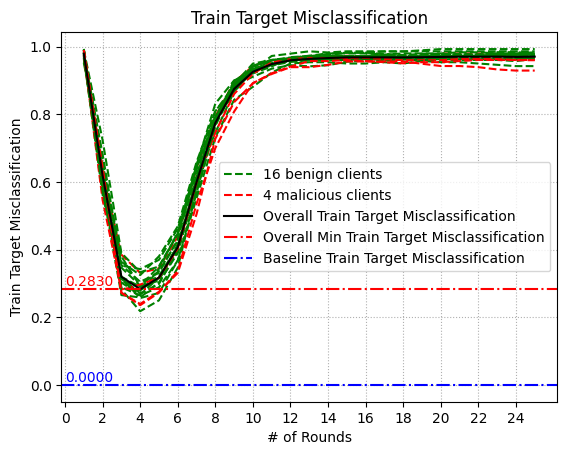

In [17]:
x = range(1, num_rounds + 1)
metric_type = "train_target_misclassification"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')

plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()

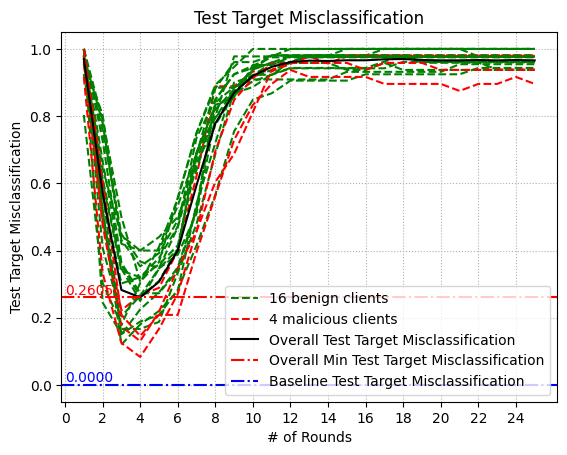

In [18]:
x = range(1, num_rounds + 1)
metric_type = "test_target_misclassification"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')

plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()

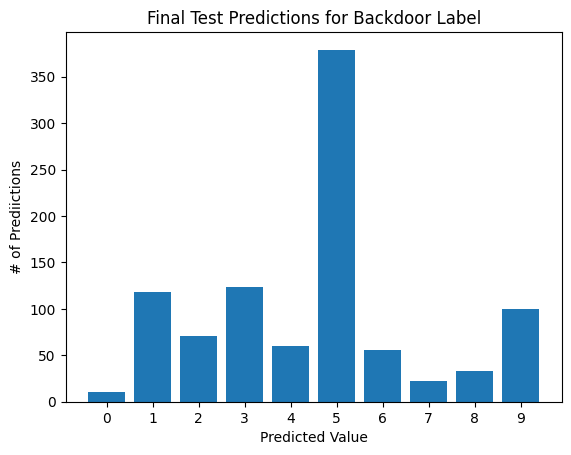

In [19]:
# Generate x-values as the index numbers of the list
data = graph_data['overall_test_target_prediction_dist'][-1]
x = range(len(data))

# Plot the bar chart
plt.bar(x, data)

# Add labels and title
plt.xlabel('Predicted Value')
plt.ylabel('# of Prediictions')
plt.title('Final Test Predictions for Backdoor Label')
plt.xticks(np.arange(0, 10, 1))

# Show the plot
plt.show()